In [2]:
#setup
data_dir='../../Data/Weather'
file_index='SSSSBBSS'
meas='SNWD'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [3]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [4]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [5]:
from pyspark import SparkContext
# sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|11183.467759022718|2476.4223902765893|  385.1362997238969|   2493.3|SSSSBBSS| 33.9833|  -109.75|       SNWD|0.09903383540055485|0.05733362444014835|0.05647398712192465|0.9695145184881404|USC00023926| 1.4368523E8|     1|[C4 60 90 60 5E 6...|1979.0|
| 76

### Plot Mean and Eigenvecs

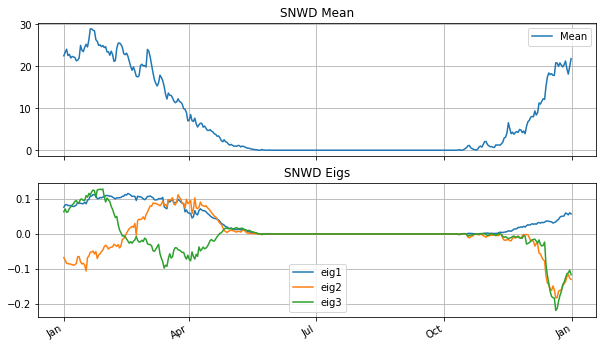

In [8]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

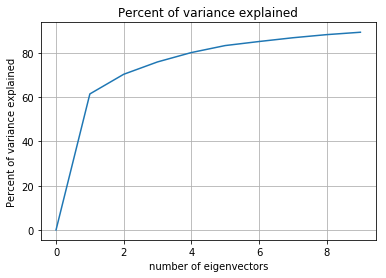

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [10]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

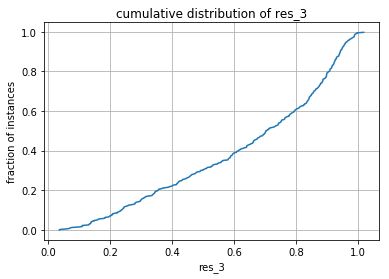

In [11]:
plot_CDF(df,'res_3')

In [12]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00023926', 1979.0)

In [13]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

39420

In [14]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [15]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [16]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00020855 3159
USC00029622 1017
USC00026597 4879
USC00022779 351
USC00023082 2791
USC00023505 322
USC00028326 1049
USC00026320 3086
USW00093139 3984
USC00029367 2423
USC00023448 364
USC00023683 12278
USC00025312 4181
USC00026601 16162
USC00297191 1756
USC00024779 4857
USC00028162 3918
USC00027876 3152
USC00029271 3899
USC00027855 3520
USC00295273 7339
USC00020159 11568
USC00023926 6024
USC00025412 24678
USC00020174 2088
USC00297386 1766
USC00020170 336
USC00021749 3103
USC00294375 4269


In [17]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(29, 39420)


In [18]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  130.905204609
RMS removing mean-by-station=  117.678548937
RMS removing mean-by-day   =  91.5009428836


/Users/gnagpal/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


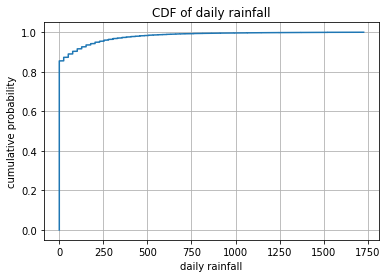

In [19]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [20]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [21]:
#USC00193270 21482
#USC00193702 28237
X=copy(All['USC00026597'])
Y=copy(All['USC00025312'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


4879
4181
0
0


In [22]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

(nan, 0)


/Users/gnagpal/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


### calculate the normalized log probability for each pair of stations.

In [23]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5 6 7 8 9 10 11

/Users/gnagpal/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28


In [24]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[-0.4  nan]
 [ nan -0.4]]


(841,) (547,)


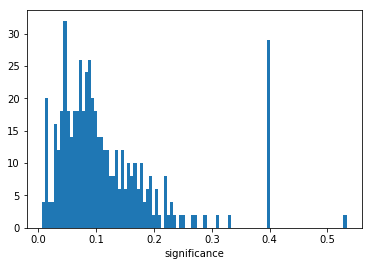

In [25]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [26]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

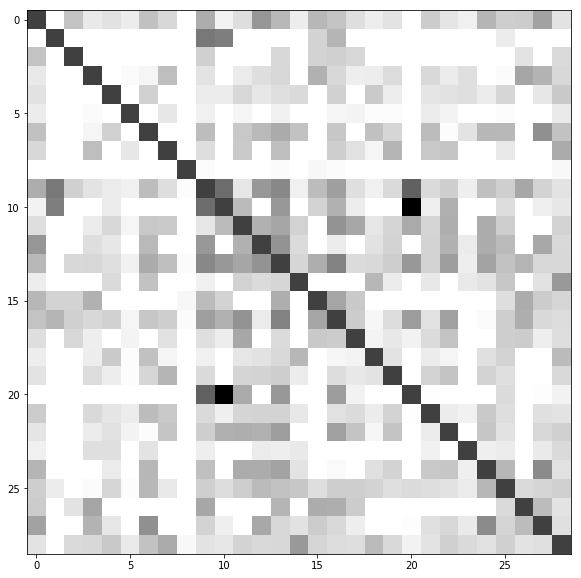

In [27]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [28]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00020855', u'USC00029622', u'USC00026597', u'USC00022779', u'USC00023082', u'USC00023505', u'USC00028326', u'USC00026320']


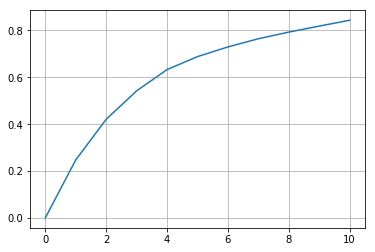

In [29]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [30]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

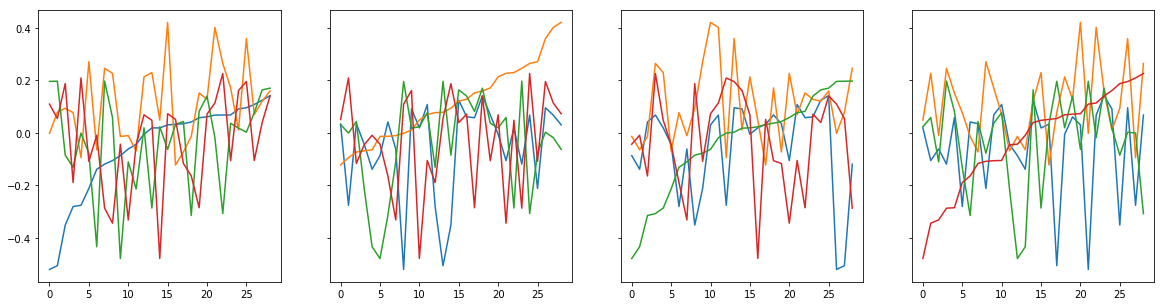

In [31]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [32]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

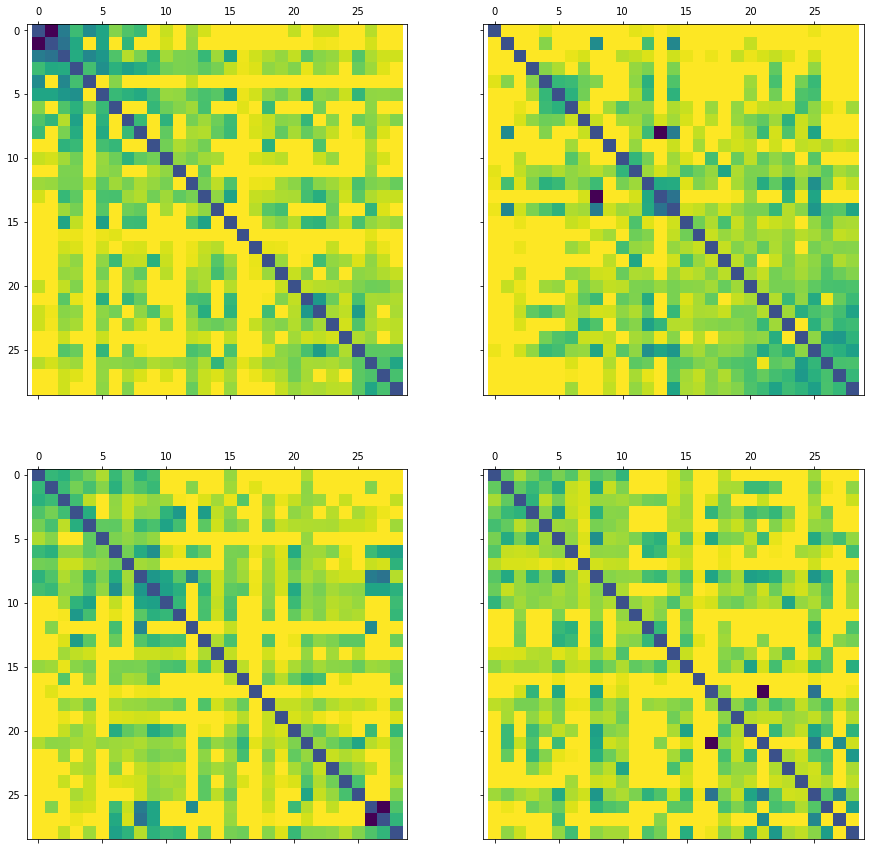

In [33]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
orders=[]
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1
        

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [34]:
from pickle import dump
with open(data_dir+'/PRCP_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    

In [35]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [48]:
order1=np.argsort(pca.components_[0,:])
print order1
stations = [Stations[i] for i in order1[:5]]
print stations

[10 20  9 16  1 13 15 11 22 26 17  2 25  0  7 12  8  5  3 19  4 24 27 21 23
  6 28 18 14]
[u'USC00023926', u'USC00028326', u'USC00023683', u'USC00026601', u'USC00020170']


In [49]:
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

393
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|11183.467759022718|2476.4223902765893| 385.1362997238969|   2493.3|SSSSBBSS| 33.9833|  -109.75|       SNWD|0.09903383540055485|0.05733362444014835|0.05647398712192465|0.9695145184881404|USC00023926|1.4368523E8|     1|[C4 60 90 60 5E 6...|1979.0|
| 7613.7

In [50]:
stats = ["'" + station + "'" for station in stations]

sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation FROM weather WHERE station in (%s)"%",".join(stats)
print(Query)
df1 = sqlContext.sql(Query)
df1.show()

SELECT station, latitude,longitude,elevation FROM weather WHERE station in ('USC00023926','USC00028326','USC00023683','USC00026601','USC00020170')
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00028326| 33.9733|-109.5631|   2856.0|
|USC00023683| 34.0219|-109.4519|   2522.2|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023683| 34.0219|-109.4519|   2522.2|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00023683| 34.0219|-109.4519|   2522.2|
|USC00023926| 33.9833|  -109.75|   2493.3|
|USC00028326| 33.9733|-109.5631|   2

In [51]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)
#define a mapping from the range of the value to hex colors.
# from matplotlib.colors import rgb2hex
# _avg='avg(%s)'%feature
# _min=pdf[_avg].min()
# _max=pdf[_avg].max()
# _min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color():
    return "#0044FF"

min_lat,max_lat,min_long,max_long = box = (32.1103, 35.6167, -111.6, -107.8)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
#     print index
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
#     _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(100*np.sqrt(500.0)), weight=1,
            color='#FB013E', opacity=1.0, fill_opacity=1.0,
            fill_color=get_color())
    circles.append(c)
    m.add_layer(c)
m    

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.
